# Anomaly Detection using fbProphet

In [1]:
!pip install fbprophet

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False


In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')

In [6]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [8]:
df = df.set_index('timestamp').resample('H').mean()

In [9]:
df.head()

,value
timestamp,
2014-07-01 00:00:00,9485.5
2014-07-01 01:00:00,5433.0
2014-07-01 02:00:00,3346.5
2014-07-01 03:00:00,2216.5
2014-07-01 04:00:00,2189.5


In [11]:
fig = px.line(df.reset_index(), x='timestamp', y='value', title='NYC Taxi demand')


fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                      dict(count=1, label='1y', step='year', stepmode='backward'),
                      dict(count=2, label='3y', step='year', stepmode='backward'),
                      dict(count=3, label='5y', step='year', stepmode='backward'),
                      dict(step='all')
                    ])
    )

)

fig.show()

In [12]:
from fbprophet import Prophet

In [13]:
taxi_df = df.reset_index()[['timestamp', 'value']].rename({'timestamp':'ds', 'value':'y'}, axis='columns')

In [14]:
taxi_df.head()

,ds,y
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5


In [15]:
train = taxi_df[(taxi_df['ds'] >= '2014-07-01') & (taxi_df['ds'] <= '2015-01-27')]
test = taxi_df[(taxi_df['ds'] > '2015-01-27')] 

In [16]:
train.shape

(5041, 2)

In [17]:
test.shape

(119, 2)

In [18]:
m = Prophet(changepoint_range=0.95)

In [19]:
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [20]:
future = m.make_future_dataframe(periods=119, freq='H')
future.tail(5)

,ds
5155,2015-01-31 19:00:00
5156,2015-01-31 20:00:00
5157,2015-01-31 21:00:00
5158,2015-01-31 22:00:00
5159,2015-01-31 23:00:00


In [21]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5155,2015-01-31 19:00:00,23778.529213,19221.421084,28379.350824
5156,2015-01-31 20:00:00,24342.584334,19821.225674,29143.355619
5157,2015-01-31 21:00:00,23219.297735,18319.582737,27833.639808
5158,2015-01-31 22:00:00,21027.355314,15786.767740,25627.431549
5159,2015-01-31 23:00:00,18500.216845,13915.179108,23101.504199


In [23]:
results = pd.concat([taxi_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]], axis=1)

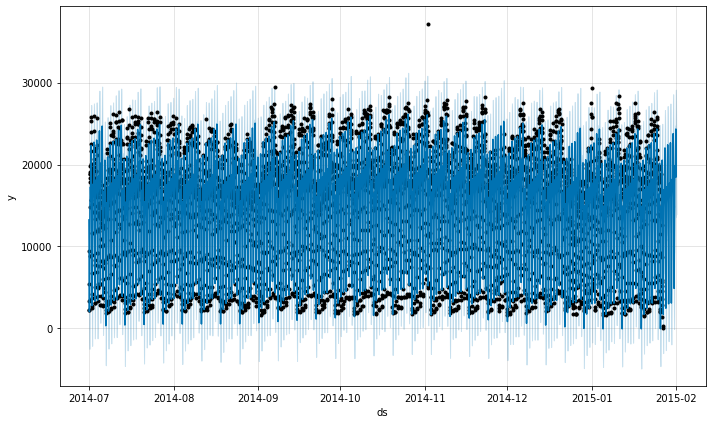

In [24]:
fig1 = m.plot(forecast)

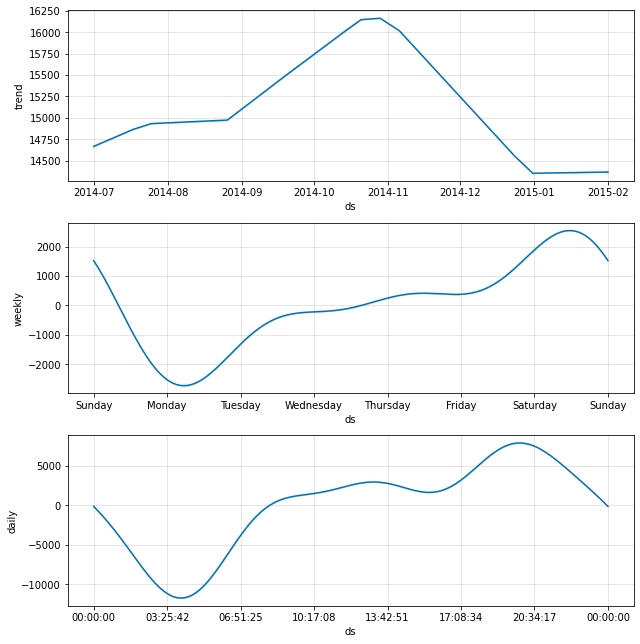

In [25]:
comp=m.plot_components(forecast)

In [26]:
results['error'] = results['y'] - results['yhat']

In [27]:
results['uncertainty'] = results['yhat_upper'] - results['yhat_lower']

In [32]:
results['anomaly'] = results.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis=1)

In [31]:
results[results['anomaly'] == 'Yes']

,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly
ds,,,,,,,
2014-11-02 01:00:00,37204.5,14218.892870,9620.787891,19083.132182,22985.607130,9462.344290,Yes
2015-01-01 01:00:00,29292.0,11405.545567,6836.033307,16199.221321,17886.454433,9363.188014,Yes
2015-01-01 02:00:00,25753.5,7770.054639,2927.060510,12767.255730,17983.445361,9840.195220,Yes
2015-01-01 03:00:00,22067.0,4478.895177,-195.321380,9164.994787,17588.104823,9360.316167,Yes
2015-01-26 19:00:00,4565.5,19771.308307,15372.675803,24624.451153,-15205.808307,9251.775351,Yes
2015-01-26 20:00:00,3630.5,20546.581743,15698.459875,24979.472315,-16916.081743,9281.012440,Yes
2015-01-26 21:00:00,2907.0,19647.710004,14895.283763,24559.694388,-16740.710004,9664.410626,Yes
2015-01-26 22:00:00,1324.5,17691.969234,12904.777409,22387.397435,-16367.469234,9482.620026,Yes
2015-01-26 23:00:00,243.0,15411.348672,10419.954866,20107.307573,-15168.348672,9687.352706,Yes
